In [3]:
import sys
import os

# Get the current working directory
current_dir = os.getcwd()

# Navigate to the parent directory
parent_dir = os.path.dirname(current_dir)

# Append the parent directory to sys.path
sys.path.append(parent_dir)

# Verify that the parent directory was added
print(sys.path[-1])

/home/yuki/quant_project/EURUSD-LSTM-prediction


In [4]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from data_processing import *
import matplotlib.pyplot as plt
import seaborn

return_test_day = [1,3,5]
prediction_parameters_dic = {"Forecast period":1, "time_rolling_window":22}


df_Macro = pd.read_csv("../Data/EURUSD_Macro.csv")
df_Macro["Last_Return"] =((df_Macro["PX_LAST"].pct_change(periods=prediction_parameters_dic["Forecast period"]))
                          )

df_Macro["Predict_Return"] = ((df_Macro["PX_LAST"].pct_change(periods=prediction_parameters_dic["Forecast period"])
                      .dropna(ignore_index = True)))

df_Macro.dropna(inplace=True)
df_Macro

,Dates,PX_OPEN,PX_HIGH,PX_LOW,PX_LAST,EURUSDV1W Curncy,EURUSDV1M Curncy,EURUSDV1Y Curncy,EURUSD25R1M Curncy,EURUSDVON Curncy,...,GTFRF2Y Govt,GTFRF10Y Govt,GTFRF30Y Govt,SPX Index,VIX Index,SX5E Index,CPI YOY Index,EACPI Index,Last_Return,Predict_Return
1,10/3/2003,1.1695,1.1722,1.1554,1.1580,11.3500,11.1500,11.2000,0.7000,15.0000,...,2.534,4.262,4.971,1029.85,19.50,2516.48,2.3,81.54,-0.009918,0.011226
2,10/6/2003,1.1563,1.1723,1.1535,1.1710,10.6000,11.3500,11.2250,0.7000,15.5000,...,2.475,4.217,4.918,1034.35,19.51,2497.10,2.3,81.54,0.011226,0.004355
3,10/7/2003,1.1710,1.1814,1.1700,1.1761,11.2500,11.6500,11.4000,0.8000,14.0000,...,2.476,4.249,4.959,1039.25,19.41,2476.61,2.3,81.54,0.004355,0.004336
4,10/8/2003,1.1761,1.1840,1.1760,1.1812,11.1250,11.6250,11.3500,0.8000,14.5000,...,2.462,4.238,4.951,1033.78,19.18,2473.88,2.3,81.54,0.004336,-0.005418
5,10/9/2003,1.1811,1.1860,1.1687,1.1748,11.5000,11.3000,11.2000,0.7750,13.5000,...,2.526,4.299,4.995,1038.73,18.82,2531.37,2.3,81.54,-0.005418,0.004256
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5422,7/15/2024,1.0903,1.0922,1.0882,1.0894,4.6725,5.0475,6.1700,-0.1475,4.4900,...,2.948,3.112,3.591,5631.22,13.12,4983.11,3.0,126.58,-0.001192,0.000459
5423,7/16/2024,1.0894,1.0905,1.0872,1.0899,4.5475,5.0575,6.1750,-0.1450,3.9925,...,2.914,3.081,3.560,5667.20,13.19,4947.83,3.0,126.58,0.000459,0.003670
5424,7/17/2024,1.0899,1.0948,1.0895,1.0939,5.0075,5.2550,6.1750,-0.1375,7.1350,...,2.924,3.075,3.551,5588.27,14.48,4891.46,3.0,126.58,0.003670,-0.003839
5425,7/18/2024,1.0939,1.0941,1.0894,1.0897,4.3325,5.0300,6.2175,-0.2125,4.4775,...,2.909,3.091,3.579,5544.59,15.93,4870.12,3.0,126.58,-0.003839,-0.001377


In [5]:
df_tech = pd.read_csv("../Data/EURUSD_OHLC.csv")
# df_tech["Dates"]=pd.to_datetime(df_tech['Dates'])
# df_tech = df_tech[df_tech["Dates"] > pd.to_datetime("2002-01-01") ] 

df_tech["Last_Return"] =((df_tech["PX_LAST"].pct_change(periods=prediction_parameters_dic["Forecast period"]))
                          )

df_tech["Predict_Return"] = ((df_tech["PX_LAST"].pct_change(periods=prediction_parameters_dic["Forecast period"])
                      .dropna(ignore_index = True)))

df_tech.dropna(inplace=True)
df_tech

,Dates,PX_OPEN,PX_HIGH,PX_LOW,PX_LAST,Last_Return,Predict_Return
1,1/3/1980,1.5177,1.5177,1.5177,1.5177,0.001848,-0.003163
2,1/4/1980,1.5129,1.5129,1.5129,1.5129,-0.003163,0.002578
3,1/7/1980,1.5168,1.5168,1.5168,1.5168,0.002578,-0.003956
4,1/8/1980,1.5108,1.5108,1.5108,1.5108,-0.003956,0.003508
5,1/9/1980,1.5161,1.5161,1.5161,1.5161,0.003508,-0.001847
...,...,...,...,...,...,...,...
11466,7/15/2024,1.0903,1.0922,1.0882,1.0894,-0.001192,0.000459
11467,7/16/2024,1.0894,1.0905,1.0872,1.0899,0.000459,0.003670
11468,7/17/2024,1.0899,1.0948,1.0895,1.0939,0.003670,-0.003839
11469,7/18/2024,1.0939,1.0941,1.0894,1.0897,-0.003839,-0.001377


In [6]:

# sys.path.append("./factors")
# import tech_indicators
from factors import tech_indicators

EURUSD_close = df_tech['PX_LAST'].to_numpy()
EURUSD_typical = ((df_tech['PX_HIGH']+df_tech['PX_LOW']+df_tech['PX_LAST'])/3).to_numpy()

tech_dict =( {"SMA":[[10]],"EMA":[[50]],"RSI":[[10],[50],[100]],"MACD":[[26,12],[12,5]],"ROC":[[2]],"Bollinger_Bands_lower":[[20],[50]],
             "Bollinger_Bands_upper":[[20],[100]],
              "CCI":[[20],[100]]} )

for key,value in tech_dict.items():
    
    for value in value:
        df_column_name = key
        for para in value:
            df_column_name += ("_"+str(para))
        
        if key[:3] == "CCI":
            df_tech[df_column_name] = tech_indicators.techindicator_to_array(EURUSD_typical,getattr(tech_indicators,key),*value)
            
        else:
            df_tech[df_column_name] = tech_indicators.techindicator_to_array(EURUSD_close,getattr(tech_indicators,key),*value)
        
df_tech.dropna(inplace=True,ignore_index=True)


df_tech

,Dates,PX_OPEN,PX_HIGH,PX_LOW,PX_LAST,Last_Return,Predict_Return,SMA_10,EMA_50,RSI_10,...,RSI_100,MACD_26_12,MACD_12_5,ROC_2,Bollinger_Bands_lower_20,Bollinger_Bands_lower_50,Bollinger_Bands_upper_20,Bollinger_Bands_upper_100,CCI_20,CCI_100
0,5/27/1980,1.4725,1.4725,1.4725,1.4725,0.008354,-0.003328,1.45190,1.429335,68.750000,...,51.536492,0.009267,0.007195,0.008354,1.431259,1.340592,1.464671,1.549607,284.727864,34.043608
1,5/28/1980,1.4676,1.4676,1.4676,1.4676,-0.003328,-0.000886,1.45396,1.429185,66.304348,...,51.528245,0.011650,0.007560,-0.003328,1.430308,1.339875,1.467772,1.548261,183.562457,27.108459
2,5/29/1980,1.4663,1.4663,1.4663,1.4663,-0.000886,-0.001159,1.45564,1.426798,73.564882,...,52.064292,0.012238,0.007066,-0.000886,1.430049,1.339321,1.470171,1.547053,142.398522,26.016046
3,5/30/1980,1.4646,1.4646,1.4646,1.4646,-0.001159,-0.001024,1.45715,1.428254,74.718275,...,52.419483,0.009106,0.006509,-0.001159,1.430514,1.339691,1.471906,1.545657,109.547574,24.332424
4,6/2/1980,1.4631,1.4631,1.4631,1.4631,-0.001024,0.000410,1.45876,1.429972,77.293462,...,52.796671,0.007851,0.006710,-0.001024,1.431261,1.340232,1.473169,1.544441,86.049131,22.846588
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11366,7/15/2024,1.0903,1.0922,1.0882,1.0894,-0.001192,0.000459,1.08319,1.079121,70.260223,...,49.415964,0.003400,0.004461,-0.001192,1.063823,1.067336,1.091007,1.095594,144.435004,102.425147
11367,7/16/2024,1.0894,1.0905,1.0872,1.0899,0.000459,0.003670,1.08473,1.079449,65.665236,...,48.609938,0.004418,0.004143,0.000459,1.063682,1.067392,1.092738,1.095752,118.739548,94.120244
11368,7/17/2024,1.0899,1.0948,1.0895,1.0939,0.003670,-0.003839,1.08626,1.080476,67.611336,...,48.951660,0.004020,0.004955,0.003670,1.063260,1.067321,1.095110,1.096080,134.613826,126.478733
11369,7/18/2024,1.0939,1.0941,1.0894,1.0897,-0.003839,-0.001377,1.08711,1.080689,57.556936,...,48.584270,0.005570,0.003988,-0.003839,1.064168,1.067334,1.096152,1.096289,106.594399,107.956277


In [7]:
df_tech_part = df_tech.iloc[:,7:]

df_tech_part["Dates"] = df_tech["Dates"]

df_tech = df_tech_part

df_tech

,SMA_10,EMA_50,RSI_10,RSI_50,RSI_100,MACD_26_12,MACD_12_5,ROC_2,Bollinger_Bands_lower_20,Bollinger_Bands_lower_50,Bollinger_Bands_upper_20,Bollinger_Bands_upper_100,CCI_20,CCI_100,Dates
0,1.45190,1.429335,68.750000,53.746414,51.536492,0.009267,0.007195,0.008354,1.431259,1.340592,1.464671,1.549607,284.727864,34.043608,5/27/1980
1,1.45396,1.429185,66.304348,54.759544,51.528245,0.011650,0.007560,-0.003328,1.430308,1.339875,1.467772,1.548261,183.562457,27.108459,5/28/1980
2,1.45564,1.426798,73.564882,58.879844,52.064292,0.012238,0.007066,-0.000886,1.430049,1.339321,1.470171,1.547053,142.398522,26.016046,5/29/1980
3,1.45715,1.428254,74.718275,58.635640,52.419483,0.009106,0.006509,-0.001159,1.430514,1.339691,1.471906,1.545657,109.547574,24.332424,5/30/1980
4,1.45876,1.429972,77.293462,60.078821,52.796671,0.007851,0.006710,-0.001024,1.431261,1.340232,1.473169,1.544441,86.049131,22.846588,6/2/1980
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11366,1.08319,1.079121,70.260223,52.304140,49.415964,0.003400,0.004461,-0.001192,1.063823,1.067336,1.091007,1.095594,144.435004,102.425147,7/15/2024
11367,1.08473,1.079449,65.665236,50.727730,48.609938,0.004418,0.004143,0.000459,1.063682,1.067392,1.092738,1.095752,118.739548,94.120244,7/16/2024
11368,1.08626,1.080476,67.611336,50.934001,48.951660,0.004020,0.004955,0.003670,1.063260,1.067321,1.095110,1.096080,134.613826,126.478733,7/17/2024
11369,1.08711,1.080689,57.556936,49.616906,48.584270,0.005570,0.003988,-0.003839,1.064168,1.067334,1.096152,1.096289,106.594399,107.956277,7/18/2024


In [8]:
df = pd.merge(left=df_Macro,right=df_tech,how="left",on="Dates")

df

,Dates,PX_OPEN,PX_HIGH,PX_LOW,PX_LAST,EURUSDV1W Curncy,EURUSDV1M Curncy,EURUSDV1Y Curncy,EURUSD25R1M Curncy,EURUSDVON Curncy,...,RSI_100,MACD_26_12,MACD_12_5,ROC_2,Bollinger_Bands_lower_20,Bollinger_Bands_lower_50,Bollinger_Bands_upper_20,Bollinger_Bands_upper_100,CCI_20,CCI_100
0,10/3/2003,1.1695,1.1722,1.1554,1.1580,11.3500,11.1500,11.2000,0.7000,15.0000,...,54.940314,0.016894,0.010259,-0.009918,1.103098,1.077703,1.176722,1.195954,90.851777,61.696460
1,10/6/2003,1.1563,1.1723,1.1535,1.1710,10.6000,11.3500,11.2250,0.7000,15.5000,...,55.524009,0.018805,0.009198,0.011226,1.107282,1.076865,1.178978,1.196111,97.427477,72.851043
2,10/7/2003,1.1710,1.1814,1.1700,1.1761,11.2500,11.6500,11.4000,0.8000,14.0000,...,55.553938,0.022266,0.009006,0.004355,1.108528,1.075710,1.183082,1.196270,128.930818,102.571822
3,10/8/2003,1.1761,1.1840,1.1760,1.1812,11.1250,11.6250,11.3500,0.8000,14.5000,...,55.491734,0.021423,0.009441,0.004336,1.110314,1.074349,1.187306,1.196846,134.577013,114.970487
4,10/9/2003,1.1811,1.1860,1.1687,1.1748,11.5000,11.3000,11.2000,0.7750,13.5000,...,54.839177,0.020003,0.005909,-0.005418,1.113640,1.073701,1.189360,1.197023,105.467974,102.902915
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5421,7/15/2024,1.0903,1.0922,1.0882,1.0894,4.6725,5.0475,6.1700,-0.1475,4.4900,...,49.415964,0.003400,0.004461,-0.001192,1.063823,1.067336,1.091007,1.095594,144.435004,102.425147
5422,7/16/2024,1.0894,1.0905,1.0872,1.0899,4.5475,5.0575,6.1750,-0.1450,3.9925,...,48.609938,0.004418,0.004143,0.000459,1.063682,1.067392,1.092738,1.095752,118.739548,94.120244
5423,7/17/2024,1.0899,1.0948,1.0895,1.0939,5.0075,5.2550,6.1750,-0.1375,7.1350,...,48.951660,0.004020,0.004955,0.003670,1.063260,1.067321,1.095110,1.096080,134.613826,126.478733
5424,7/18/2024,1.0939,1.0941,1.0894,1.0897,4.3325,5.0300,6.2175,-0.2125,4.4775,...,48.584270,0.005570,0.003988,-0.003839,1.064168,1.067334,1.096152,1.096289,106.594399,107.956277


In [9]:
df.columns

Index(['Dates', 'PX_OPEN', 'PX_HIGH', 'PX_LOW', 'PX_LAST', 'EURUSDV1W Curncy',
       'EURUSDV1M Curncy', 'EURUSDV1Y Curncy', 'EURUSD25R1M Curncy',
       'EURUSDVON Curncy', 'EUR1M Curncy', 'EUR12M Curncy', 'DXY Curncy',
       'GOLDS Comdty', 'CL1 Comdty', 'FEDL01 Index', 'LF94TRUU Index',
       'USGG2YR Index', 'USGG10YR Index', 'USGG30YR Index', 'GTDEM2Y Govt',
       'GTDEM10Y Govt', 'GTDEM30Y Govt', 'GTFRF2Y Govt', 'GTFRF10Y Govt',
       'GTFRF30Y Govt', 'SPX Index', 'VIX Index', 'SX5E Index',
       'CPI YOY Index', 'EACPI Index', 'Last_Return', 'Predict_Return',
       'SMA_10', 'EMA_50', 'RSI_10', 'RSI_50', 'RSI_100', 'MACD_26_12',
       'MACD_12_5', 'ROC_2', 'Bollinger_Bands_lower_20',
       'Bollinger_Bands_lower_50', 'Bollinger_Bands_upper_20',
       'Bollinger_Bands_upper_100', 'CCI_20', 'CCI_100'],
      dtype='object')

In [10]:
df["2Y spread"] = df['GTDEM2Y Govt']-df["USGG2YR Index"]
df["10Y spread"] = df['GTDEM10Y Govt']-df["USGG10YR Index"]
df["30Y spread"] = df['GTDEM10Y Govt']-df['USGG30YR Index']

In [11]:
split_point = int(df.shape[0]*0.9)
df_train = df.iloc[:split_point,:]
df_test = df.iloc[split_point:,:]

x_train = df_train.drop(columns=["Dates","Predict_Return"]).to_numpy()
y_train = df_train.loc[:, "Predict_Return"].to_numpy()

x_test = df_test.drop(columns=["Dates","Predict_Return"]).to_numpy()
y_test = df_test.loc[:, "Predict_Return"].to_numpy()

scale_x = StandardScaler()

x_train_norm = scale_x.fit_transform(x_train)
x_test_norm = scale_x.transform(x_test)

time_delta = prediction_parameters_dic["time_rolling_window"]
x_train_norm_rolling,x_test_norm_rolling = rolling_split(x_train_norm,time_delta),rolling_split(x_test_norm,time_delta)
y_train_rolling,y_test_rolling = y_train[time_delta-1:,...],y_test[time_delta-1:,...]

threshold = threshold_search(y_train,1e-6)

print(threshold)

# set the threshold manually


0.001947


In [12]:
y_train_rolling_label , y_test_rolling_label  = labelize(y_train_rolling,threshold),labelize(y_test_rolling,threshold) 

train_set = torch.utils.data.TensorDataset(torch.from_numpy(x_train_norm_rolling),torch.from_numpy(y_train_rolling_label).to(torch.int64))

test_set = torch.utils.data.TensorDataset(torch.from_numpy(x_test_norm_rolling),torch.from_numpy(y_test_rolling_label).to(torch.int64))

train_loader = torch.utils.data.DataLoader(train_set,batch_size=32,shuffle=True)

real_results = test_set[:][1]

print(len(real_results[real_results==0]))
print(len(real_results[real_results==1]))
print(len(real_results[real_results==2]))

151
204
167


In [13]:
import time_net

hyperparas = {'input_dim':x_train.shape[-1],'hidden_dim':32,'hidden_nums':2,'output_dim':3,'block_layer_nums':2, 'LSTM_layer_nums':1
        , 'dropout_rate':0.5}

net_test = time_net.LSTM_Net(hyperparas=hyperparas)

device = torch.device('cuda')

net_test.to(device=device,dtype=torch.float64)
loss = nn.CrossEntropyLoss()

def train_epoch(loss_function, optimizer, model, loader,train_data,test_data):
  loss_train = 0
  loss_test = 0
  
  for(i, (x, y)) in enumerate(loader):
    # Clear the gradients
    optimizer.zero_grad()
    x=x.to(device=device)
    y=y.to(device=device)
    # Run a forward pass
    outputs = model.forward(x)
    # Compute the batch loss
    loss = loss_function(outputs,y)
    # Calculate the gradients
    loss.backward()
    # Update the parameteres
    optimizer.step()
    
  with torch.no_grad():
    train_outputs = model.forward(train_data[:][0].to(device=device))
    train_loss = loss_function(train_outputs,train_data[:][1].to(device=device))
    loss_train = train_loss.detach().cpu()
    print(f"train loss is {train_loss}")
    
    test_outputs = model.forward(test_data[:][0].to(device=device))
    test_loss = loss_function(test_outputs,test_data[:][1].to(device=device))
    loss_test = test_loss.detach().cpu()
    print(f"test loss is {test_loss}")
  return [loss_train, loss_test]   

def train_model(loss_function, optimizer, model, loader,train_data,test_data,epochs=25):
  loss_ls = []
  for i in range(epochs):
    print(f"-----------------------Epoch: {i+1}----------------------------------")
    loss_ls.append(train_epoch(loss_function, optimizer, model, loader,train_data,test_data))
  return loss_ls    

/home/yuki/miniconda3/envs/initial/lib/python3.12/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [14]:
optim_Adam = torch.optim.Adam(net_test.parameters(),lr = 0.0001)
epochs = 100
loss_ls = train_model(loss_function=loss,optimizer=optim_Adam,model=net_test,loader=train_loader,train_data=train_set,
                      test_data=test_set,epochs=epochs)

-----------------------Epoch: 1----------------------------------
train loss is 1.2511900585894966
test loss is 1.2821515276025275
-----------------------Epoch: 2----------------------------------
train loss is 1.2000985714094596
test loss is 1.229851910616998
-----------------------Epoch: 3----------------------------------
train loss is 1.1632606451792606
test loss is 1.238264872681114
-----------------------Epoch: 4----------------------------------
train loss is 1.15413908847602
test loss is 1.1934066047093206
-----------------------Epoch: 5----------------------------------
train loss is 1.141456312121976
test loss is 1.2001899760190466
-----------------------Epoch: 6----------------------------------
train loss is 1.133626824882561
test loss is 1.1650237571892463
-----------------------Epoch: 7----------------------------------
train loss is 1.1204008840186697
test loss is 1.184449911236677
-----------------------Epoch: 8----------------------------------
train loss is 1.11407156

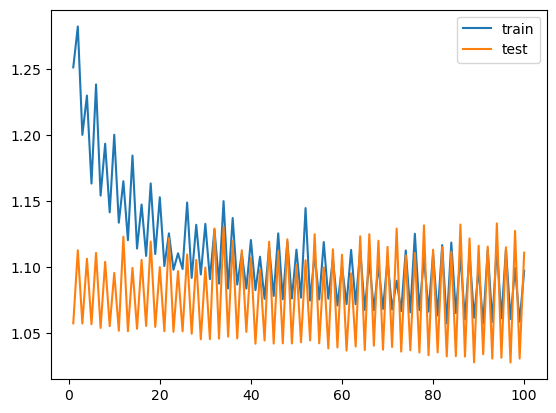

In [15]:
loss_array = np.array(loss_ls).reshape((2,epochs))
plt.plot(range(1,len(loss_array[0])+1),loss_array[0],label = "train")
plt.plot(range(1,len(loss_array[1])+1),loss_array[1],label= "test")
plt.legend()
plt.show()

In [16]:
import torch.nn.functional as F
from sklearn.metrics import accuracy_score

net_test.to(device=torch.device("cpu"))

net_test.eval()

predict_probability = torch.max(F.softmax(net_test(test_set[:][0]),dim=-1),dim=-1)[0]

predict_results = torch.argmax(F.softmax(net_test(test_set[:][0]),dim=-1),dim=-1)
real_results = test_set[:][1]

accuracy_score(real_results,predict_results)

0.4003831417624521

In [24]:
act_predict_bool = (predict_results != 1) & (predict_probability > 0.44)

act_predict_results = predict_results[act_predict_bool]
act_real_results = real_results[act_predict_bool]

accuracy_score(act_predict_results,act_real_results)

0.4098360655737705

In [25]:
act_predict_results.shape

torch.Size([61])

In [26]:
saved_path = "../trained_model/EURUSD_Mix_LSTM.pth"

torch.save(net_test.state_dict(),saved_path)